**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../run_config_project_sing.R")))
suppressMessages(suppressWarnings(library(GenomicDistributions)))
suppressMessages(suppressWarnings(library(GenomicRanges)))
show_env()

You are working on        Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
REPO DIRECTORY (FD_REPO): /data/reddylab/Kuei/repo 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/work 
DATA DIRECTORY (FD_DATA): /data/reddylab/Kuei/data 

You are working with      ENCODE FCC 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC 
PROJECT RESULTS (FD_RES): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/results 
PROJECT SCRIPTS (FD_EXE): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/scripts 
PROJECT DATA    (FD_DAT): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/data 
PROJECT NOTE    (FD_NBK): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/notebooks 
PROJECT DOCS    (FD_DOC): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/docs 
PROJECT LOG     (FD_LOG): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/log 
PROJECT REF     (FD_REF): /data/reddylab/Kuei/repo/Proj_ENCODE_FCC/references 



## Import data

**Helper function: loading data**

In [2]:
fun_load_data = function(txt_region_fdiry){
    ### set file directory
    txt_fdiry  = file.path(txt_region_fdiry, "summary")
    txt_fname = "description.tsv"
    txt_fpath = file.path(txt_fdiry, txt_fname)
    
    ### get column names
    dat = read_tsv(txt_fpath, show_col_types = FALSE)
    vec_txt_cname = dat$Name

    ### set file directory
    txt_fdiry  = file.path(txt_region_fdiry, "summary")
    txt_fname = "metadata.label.tsv"
    txt_fpath = file.path(txt_fdiry, txt_fname)
    
    ### get file labels
    dat_metadata = read_tsv(txt_fpath, show_col_types = FALSE)
    
    ### set directory
    txt_fdiry  = txt_region_fdiry
    txt_fglob  = file.path(txt_fdiry, "*bed*")
    
    ### get file names and labels
    vec_txt_fpath = Sys.glob(txt_fglob)
    vec_txt_fname = basename(vec_txt_fpath)
    vec_txt_label = fun_str_map_match(
        vec_txt_fname, 
        dat_metadata$FName, 
        dat_metadata$Label, 
        .default=vec_txt_fname)

    ### further modification of labels
    vec_txt_label = gsub("^dnase", "DNase", vec_txt_label)
    vec_txt_label = gsub("^atac",  "ATAC",  vec_txt_label)
    vec_txt_label = gsub(
        "fcc_astarr_macs_input_union", 
        "ASTARR Input (Union)",  
        vec_txt_label)
    vec_txt_label = gsub(
        "fcc_astarr_macs_input_overlap", 
        "ASTARR Input (Overlap)",  
        vec_txt_label)
    
    ### read all region files
    lst = lapply(vec_txt_fpath, function(txt_fpath){
        dat = read_tsv(txt_fpath, col_names = vec_txt_cname, show_col_types = FALSE)
        return(dat)
    })
    names(lst) = vec_txt_label
    
    return(lst)
}

**Load data**

In [3]:
### set file directory
txt_folder = "fcc_astarr_macs"
txt_fdiry  = file.path(FD_RES, "region", txt_folder)

### read tables
lst = fun_load_data(txt_fdiry)

### assign and show
lst_dat_region_astarr_input = lst
print(lapply(lst, nrow))

$`ASTARR Input (Overlap)`
[1] 150042

$`ASTARR Input (Union)`
[1] 246852



In [4]:
### set file directory
txt_folder = "encode_open_chromatin"
txt_fdiry  = file.path(FD_RES, "region", txt_folder)

### read tables
lst = fun_load_data(txt_fdiry)

### assign and show
lst_dat_region_encode_ocr = lst
print(lapply(lst, nrow))

$DNase_ENCFF274YGF
[1] 118721

$DNase_ENCFF185XRG
[1] 159277

$ATAC_ENCFF558BLC
[1] 203874

$ATAC_ENCFF925CYR
[1] 123009

$ATAC_ENCFF333TAT
[1] 269800

$ATAC_ENCFF948AFM
[1] 181340



**Convert dataframe to granges**

In [5]:
### init
lst_dat = lst_dat_region_astarr_input

### setup granges
lst_grg = lapply(lst_dat, function(dat){
    ### filter out ChrY
    vec = paste0("chr", c(1:22, "X"))
    dat = dat %>% dplyr::filter(Chrom %in% vec)

    ### dataframe -> granges     
    grg = GRanges(
        seqnames = dat$Chrom,
        ranges   = IRanges(start = dat$ChromStart, end = dat$ChromEnd)
    )
    return(grg)
})

### preserve labels
names(lst_grg) = names(lst_dat)

### create grangesList
lst_grg = GRangesList(lst_grg)

### assign and show
lst_grg_region_astarr_input = lst_grg

In [6]:
### init
lst_dat = lst_dat_region_encode_ocr

### setup granges
lst_grg = lapply(lst_dat, function(dat){
    ### filter out ChrY
    vec = paste0("chr", c(1:22, "X"))
    dat = dat %>% dplyr::filter(Chrom %in% vec)

    ### dataframe -> granges     
    grg = GRanges(
        seqnames = dat$Chrom,
        ranges   = IRanges(start = dat$ChromStart, end = dat$ChromEnd)
    )
    return(grg)
})

### preserve labels
names(lst_grg) = names(lst_dat)

### create grangesList
lst_grg = GRangesList(lst_grg)

### assign and show
lst_grg_region_encode_ocr = lst_grg

## Summarize

In [208]:
lst_grg = lst_grg_region_astarr_input
lst_dat = list(
    ### aggregate and count the distribution of regions across bins of ref genome
    "chrom_bin_cnt" = suppressMessages(calcChromBinsRef(         lst_grg, "hg38", binCount = 3000)),

    ### distance of each region to its nearest feature element
    "fdist_tss_frq" = suppressMessages(calcFeatureDistRefTSS(    lst_grg, "hg38")),
    
    ### partition distribution by different gencode element (UTR, exon, intron, etc)
    "gcode_par_frq" = suppressMessages(calcPartitionsRef(        lst_grg, "hg38")),
    "gcode_par_ove" = suppressMessages(calcExpectedPartitionsRef(lst_grg, "hg38"))
)

lst_dat_stats_astarr_input = lst_dat

In [209]:
lst_grg = lst_grg_region_encode_ocr
lst_dat = list(
    ### aggregate and count the distribution of regions across bins of ref genome
    "chrom_bin_cnt" = suppressMessages(calcChromBinsRef(         lst_grg, "hg38", binCount = 3000)),

    ### distance of each region to its nearest feature element
    "fdist_tss_frq" = suppressMessages(calcFeatureDistRefTSS(    lst_grg, "hg38")),
    
    ### partition distribution by different gencode element (UTR, exon, intron, etc)
    "gcode_par_frq" = suppressMessages(calcPartitionsRef(        lst_grg, "hg38")),
    "gcode_par_ove" = suppressMessages(calcExpectedPartitionsRef(lst_grg, "hg38"))
)

lst_dat_stats_encode_ocr = lst_dat

## Explore data

### Chromosome distribution (Genomic distribution)

In [116]:
### set text size
theme_text = theme(
    title        = element_text(size = 16),
    axis.title   = element_text(size = 16),
    axis.text    = element_text(size = 12),
    legend.title = element_text(size = 0),
    legend.text  = element_text(size = 14),
    strip.text.y = element_text(size = 14)
)

**ASTARR Input MACS peaks**

Warning message:
"Removed 246 rows containing missing values or values outside the scale range (`geom_bar()`)."


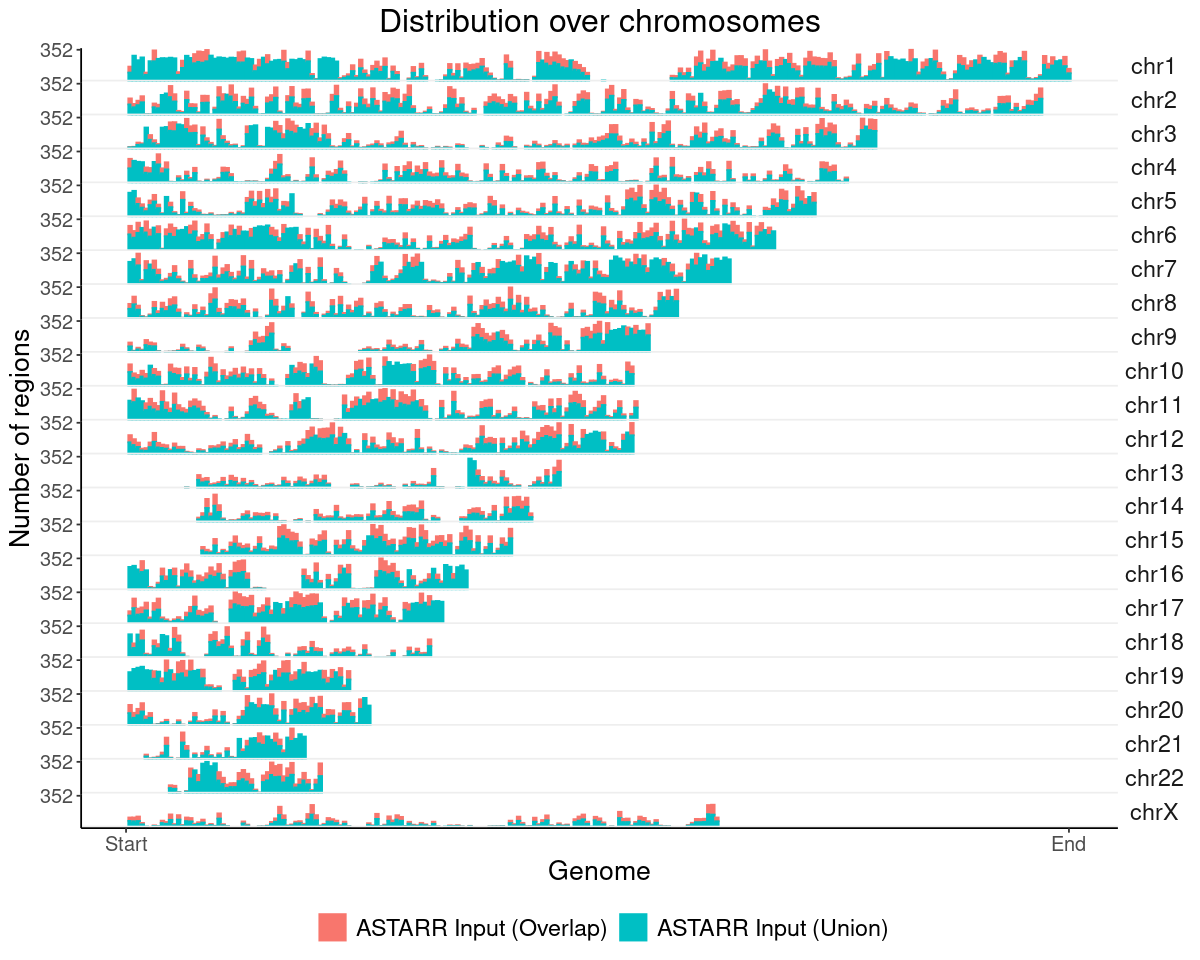

In [117]:
### get data
lst = lst_dat_stats_astarr_input
dat = lst[["chrom_bin_cnt"]]
gpt = plotChromBins(dat)
gpt = gpt + theme_text

### assign plot
gpt_astarr_input = gpt

### show plot
options(repr.plot.height=8, repr.plot.width=10)
gpt

**ENCODE Open chromatin regions**

Warning message:
"Removed 1578 rows containing missing values or values outside the scale range
(`geom_bar()`)."


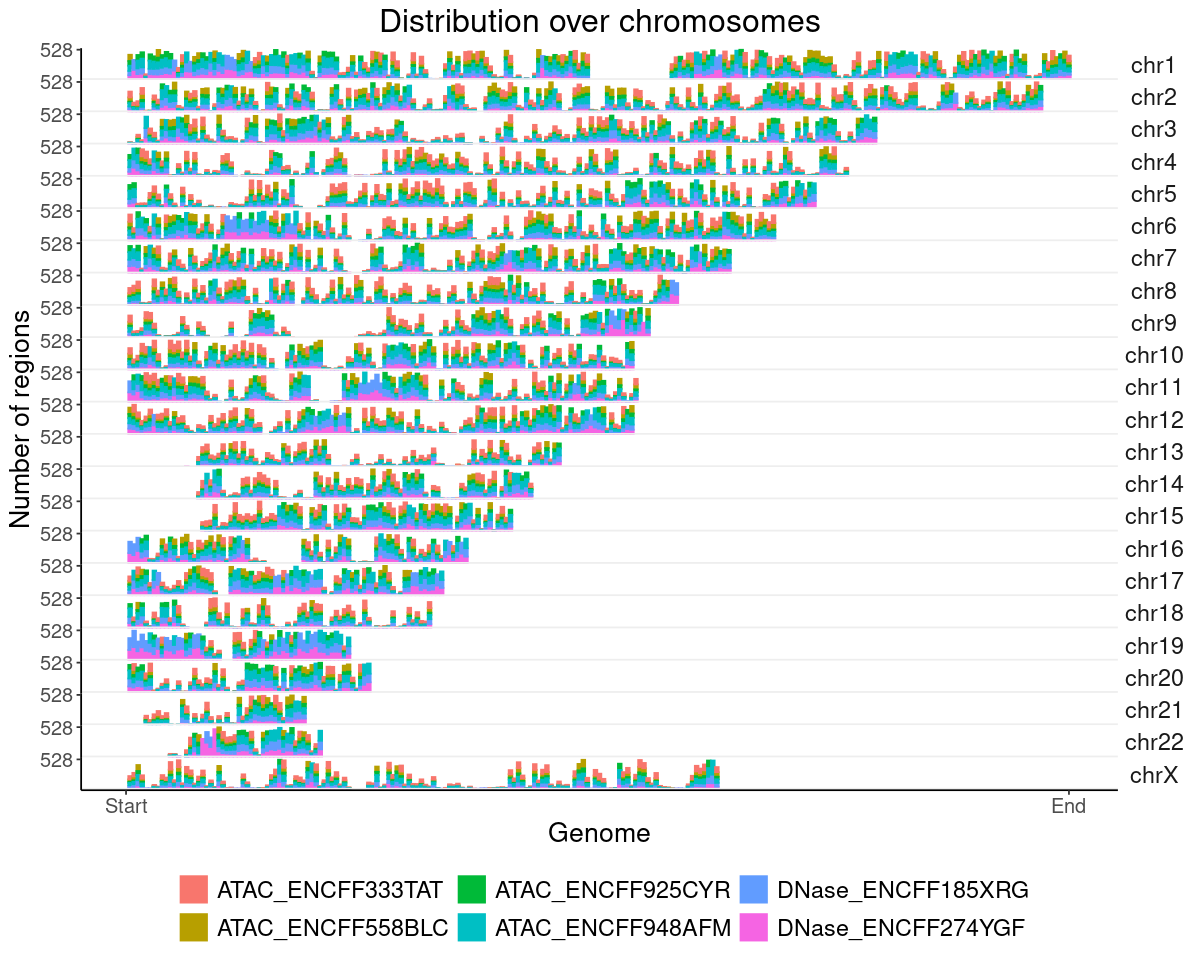

In [118]:
### get data
lst = lst_dat_stats_encode_ocr
dat = lst[["chrom_bin_cnt"]]
gpt = plotChromBins(dat)
gpt = gpt + theme_text

### assign plot
gpt_encode_ocr = gpt

### show plot
options(repr.plot.height=8, repr.plot.width=10)
gpt

**Combine and save**

Warning message:
"Removed 246 rows containing missing values or values outside the scale range (`geom_bar()`)."
Warning message:
"Removed 1578 rows containing missing values or values outside the scale range
(`geom_bar()`)."


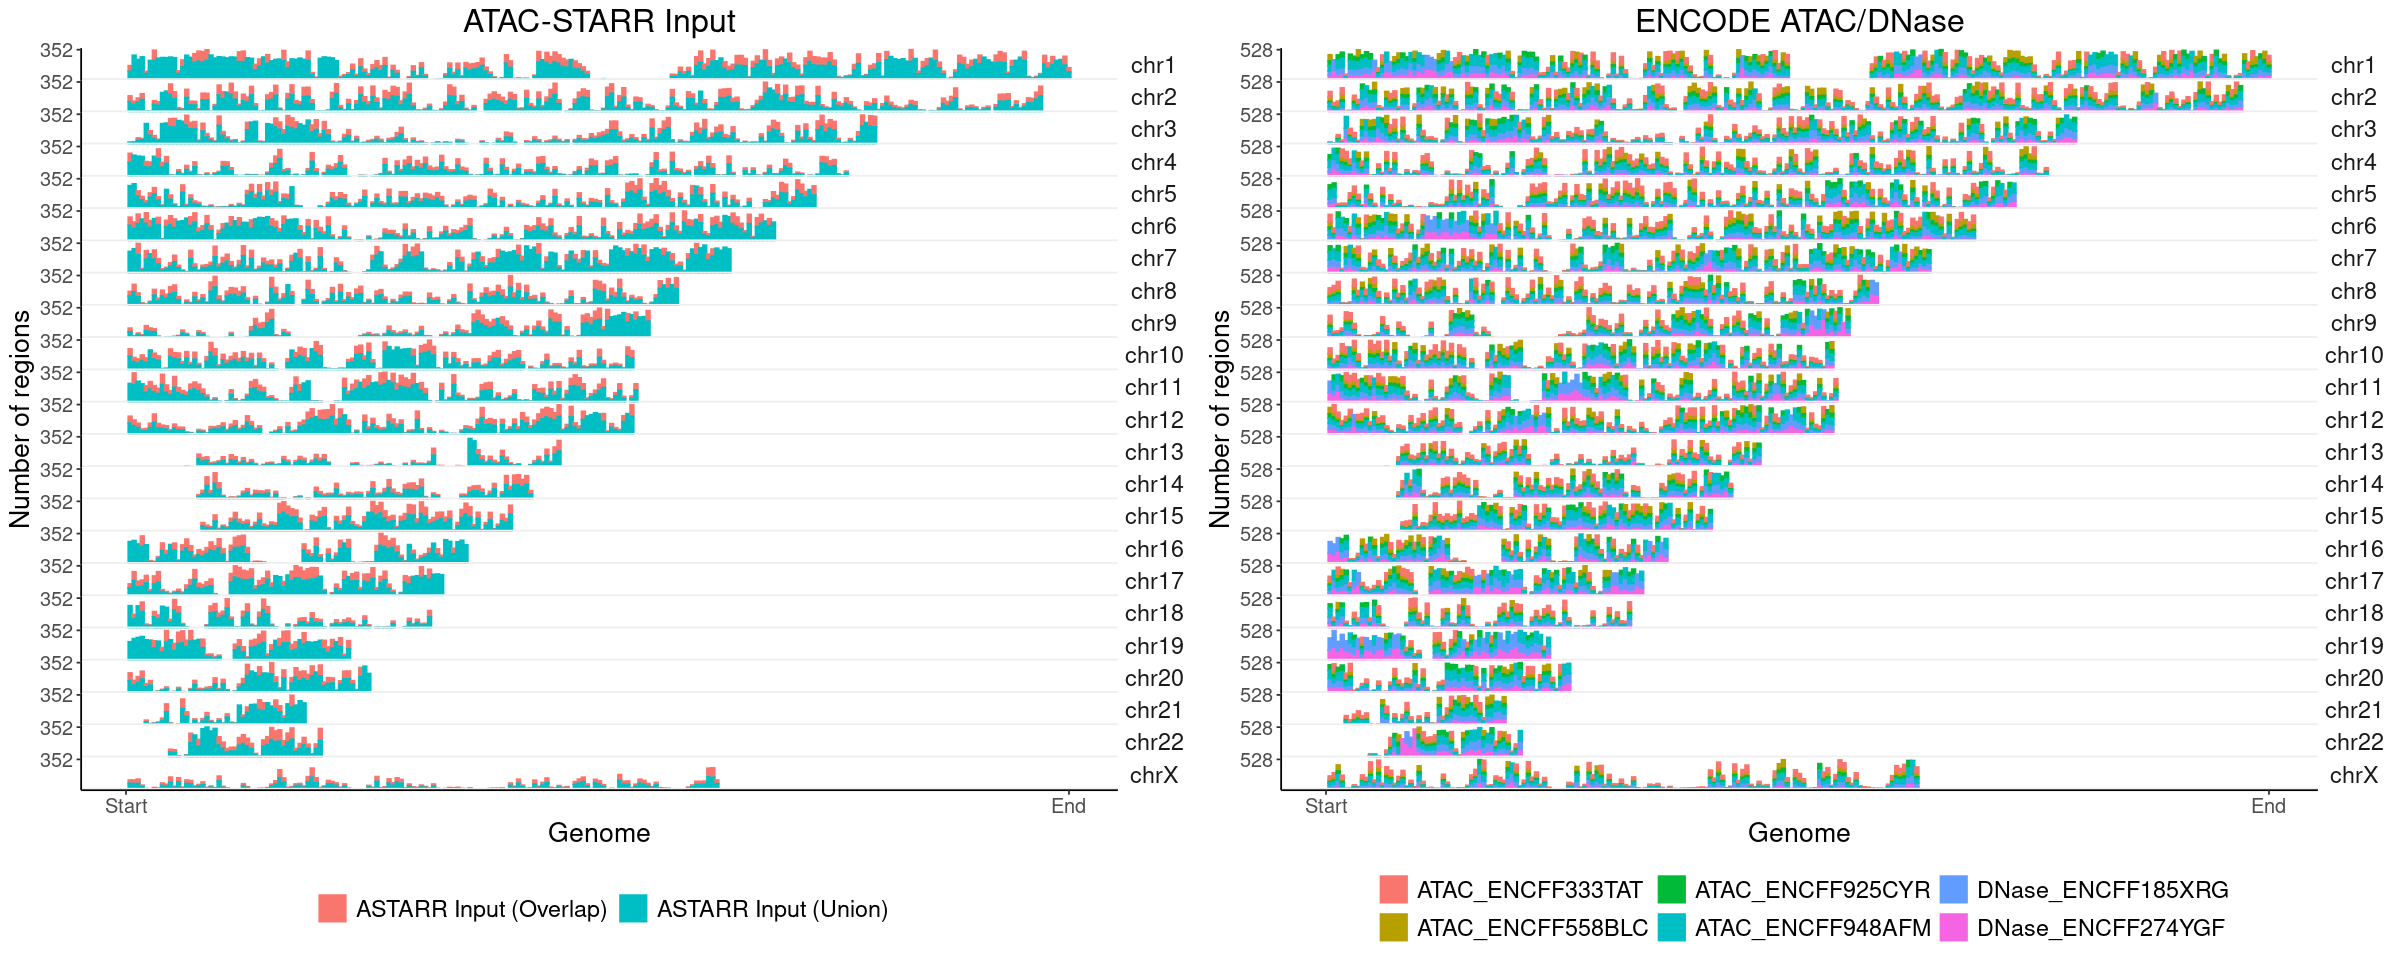

In [119]:
### combine plot
plt = plot_grid(
    gpt_astarr_input + labs(title = "ATAC-STARR Input"), 
    gpt_encode_ocr   + labs(title = "ENCODE ATAC/DNase"),
    nrow  = 1,
    align = "h"
)
plt_export = plt

### show plot
options(repr.plot.height=8, repr.plot.width=20)
print(plt)

In [120]:
txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.distribution.chromosome.png"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.distribution.chromosome.svg"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

### Percentage partition distribution plots

In [210]:
### set text size
theme_text = theme(
    title        = element_text(size = 14),
    axis.title   = element_text(size = 14),
    axis.text    = element_text(size = 14),
    legend.title = element_text(size = 0),
    legend.text  = element_text(size = 12)
)

**ASTARR Input MACS peaks**

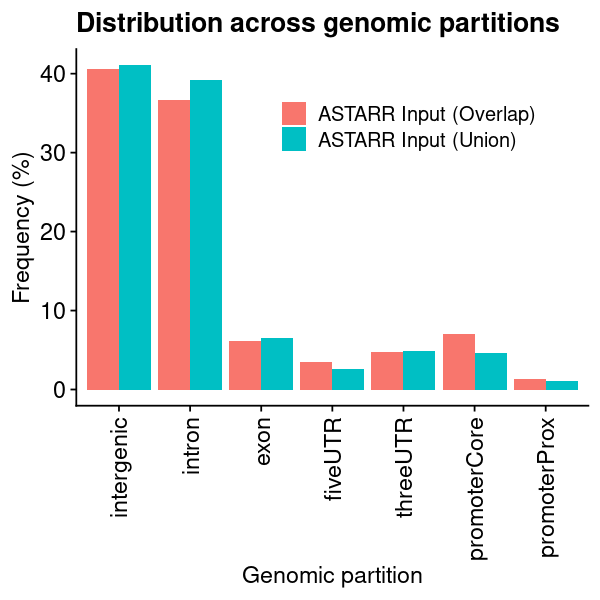

In [214]:
### arrange data
lst = lst_dat_stats_astarr_input
dat = lst[["gcode_par_frq"]]

### Fix warning: .internal.selfref
### [.data.table(df, , :=(FreqPercent, Freq/sum(Freq) * 100)
dat = data.table::copy(dat)
dat[, FreqPercent := Freq/sum(Freq)*100]

### reorder genomic partition
vec = c("intergenic", "intron", "exon", "fiveUTR", "threeUTR", "promoterCore", "promoterProx")
dat = dat %>% dplyr::mutate(partition = factor(partition, levels=vec))

### generate plot
gpt = plotPartitions(dat)
gpt = gpt + theme_cowplot()
gpt = gpt + theme_text
gpt = gpt + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
gpt = gpt + theme(
    legend.position = "inside", 
    legend.position.inside = c(0.4, 0.8),
    legend.background = element_rect(fill = "white")
)

### assign plot
gpt_astarr_input = gpt

### show plot
options(repr.plot.height=5, repr.plot.width=5)
gpt

**ENCODE Open chromatin regions**

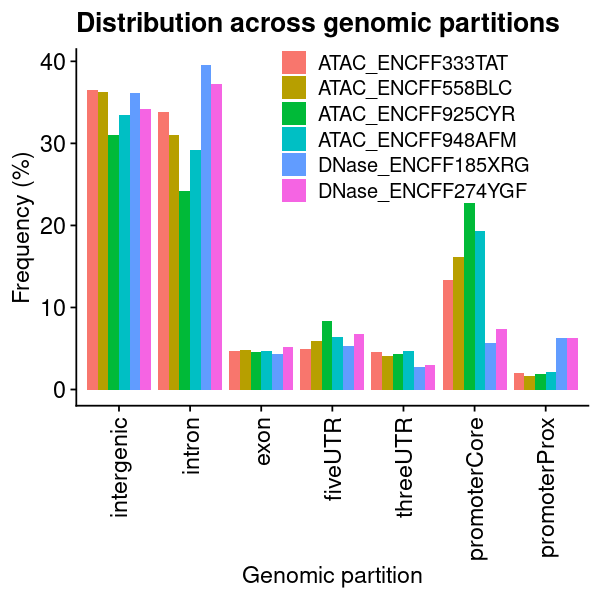

In [215]:
### arrange data
lst = lst_dat_stats_encode_ocr
dat = lst[["gcode_par_frq"]]

### Fix warning: .internal.selfref
### [.data.table(df, , :=(FreqPercent, Freq/sum(Freq) * 100)
dat = data.table::copy(dat)
dat[, FreqPercent := Freq/sum(Freq)*100]

### reorder genomic partition
vec = c("intergenic", "intron", "exon", "fiveUTR", "threeUTR", "promoterCore", "promoterProx")
dat = dat %>% dplyr::mutate(partition = factor(partition, levels=vec))

### generate plot
gpt = plotPartitions(dat)
gpt = gpt + theme_cowplot()
gpt = gpt + theme_text
gpt = gpt + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
gpt = gpt + theme(
    legend.position = "inside", 
    legend.position.inside = c(0.4, 0.8),
    legend.background = element_rect(fill = "white")
)

### assign plot
gpt_encode_ocr = gpt

### show plot
options(repr.plot.height=5, repr.plot.width=5)
gpt

**Combine and save**

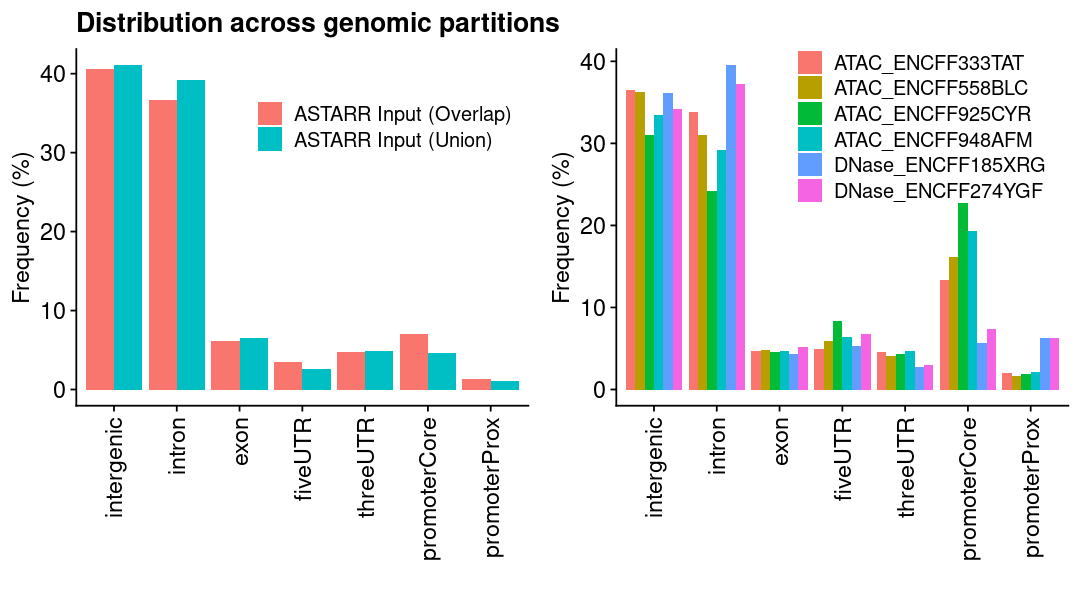

In [216]:
### combine plot
plt = plot_grid(
    gpt_astarr_input + labs(x = "") + theme(plot.title = element_text(hjust = 0)), 
    gpt_encode_ocr   + labs(title = "", x = ""),
    nrow  = 1,
    align = "h"
)

### assign plot
plt_export = plt

### show plot
options(repr.plot.height=5, repr.plot.width=9)
print(plt)

In [217]:
txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.frequency.genomic_partition.png"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.frequency.genomic_partition.svg"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

### Odds partition distribution plots

In [220]:
### set text size
theme_text = theme(
    title        = element_text(size = 14),
    axis.title   = element_text(size = 14),
    axis.text    = element_text(size = 14),
    legend.title = element_text(size = 0),
    legend.text  = element_text(size = 10)
)

**ASTARR Input MACS peaks**

In [221]:
lst = lst_dat_stats_astarr_input
dat = lst[["gcode_par_ove"]]
head(dat)

partition,observed,expected,log10OE,Chi.square.pval,method,name
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
promoterCore,10559,86.03854,2.088929755,0.00e+00,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)
promoterProx,2026,1633.90980,0.093411363,7.80e-11,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)
threeUTR,7065,2006.08224,0.546763433,0.00e+00,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)
fiveUTR,5173,467.16997,1.044267564,0.00e+00,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)
exon,9212,2112.67148,0.639521960,0.00e+00,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)
intron,55058,55991.45493,-0.007301321,4.23e-04,Pearson's Chi-squared test with Yates' continuity correction,ASTARR Input (Overlap)


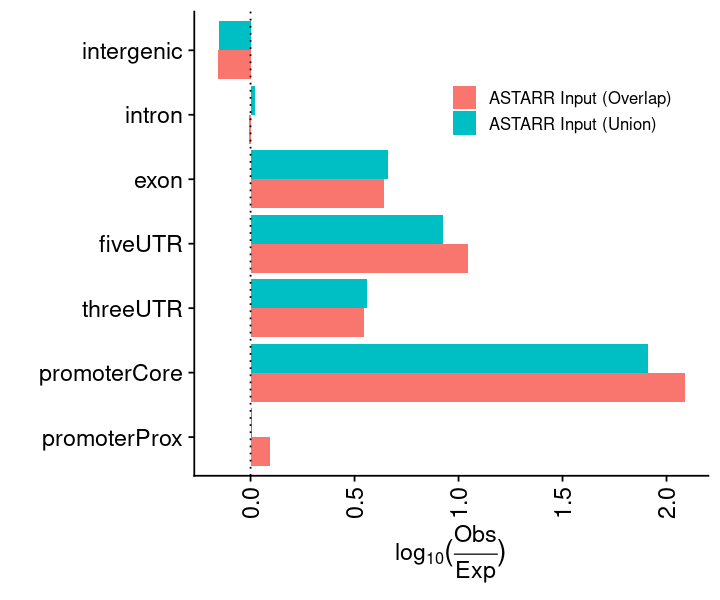

In [235]:
### arrange data
lst = lst_dat_stats_astarr_input
dat = lst[["gcode_par_ove"]]

### Fix warning: .internal.selfref
dat = data.table::copy(dat)

### reorder genomic partition
vec = c("intergenic", "intron", "exon", "fiveUTR", "threeUTR", "promoterCore", "promoterProx")
dat = dat %>% dplyr::mutate(partition = factor(partition, levels=rev(vec)))

### generate plot
gpt = plotExpectedPartitions(dat)
gpt = gpt + scale_y_continuous(breaks = seq(0, 3, by=0.5))
gpt = gpt + theme_cowplot()
gpt = gpt + theme_text
gpt = gpt + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
gpt = gpt + theme(
    legend.position = "inside", 
    legend.position.inside = c(0.5, 0.8),
    legend.background = element_rect(fill = "white")
)

### assign plot
gpt_astarr_input = gpt

### show plot
options(repr.plot.height=5, repr.plot.width=6)
gpt

**ENCODE Open chromatin regions**

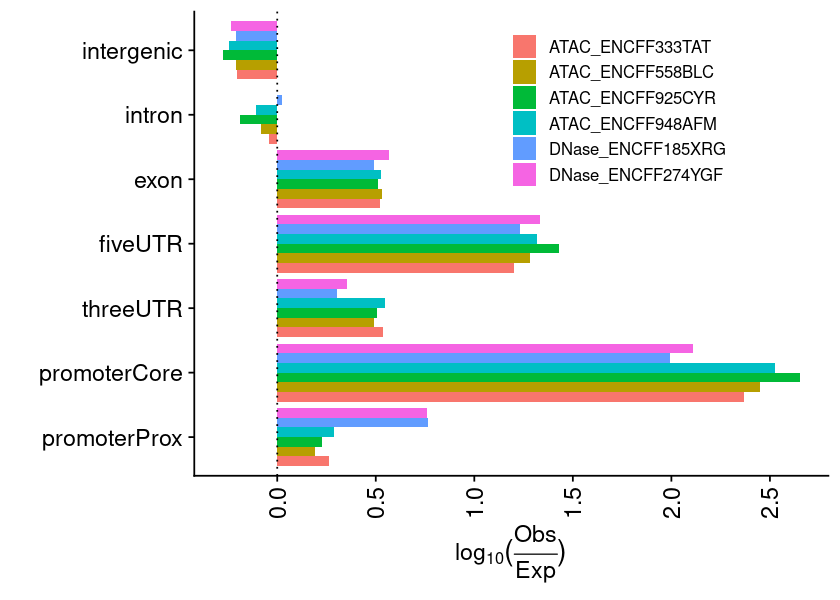

In [236]:
### get data
lst = lst_dat_stats_encode_ocr
dat = lst[["gcode_par_ove"]]

### Fix warning: .internal.selfref
dat = data.table::copy(dat)

### reorder genomic partition
vec = c("intergenic", "intron", "exon", "fiveUTR", "threeUTR", "promoterCore", "promoterProx")
dat = dat %>% dplyr::mutate(partition = factor(partition, levels=rev(vec)))

### generate plot
gpt = plotExpectedPartitions(dat)
gpt = gpt + scale_y_continuous(breaks = seq(0, 3, by=0.5))
gpt = gpt + theme_cowplot()
gpt = gpt + theme_text
gpt = gpt + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
gpt = gpt + theme(
    legend.position = "inside", 
    legend.position.inside = c(0.5, 0.8),
    legend.background = element_rect(fill = "white")
)

### assign plot
gpt_encode_ocr = gpt

### show plot
options(repr.plot.height=5, repr.plot.width=7)
gpt

**Combine and save**

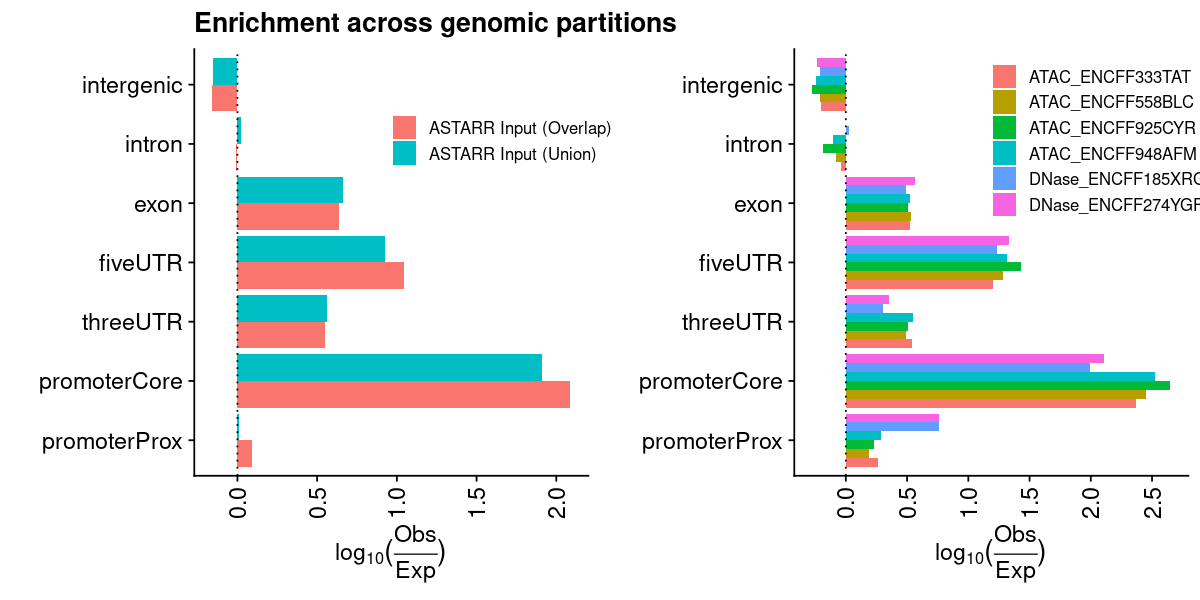

In [237]:
### combine plot
plt = plot_grid(
    gpt_astarr_input + labs(title="Enrichment across genomic partitions"), 
    gpt_encode_ocr,
    nrow  = 1,
    align = "h"
)

### assign plot
plt_export = plt

### show plot
options(repr.plot.height=5, repr.plot.width=10)
print(plt)

In [238]:
txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.enrichment.genomic_partition.png"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

txt_fdiry = "./"
txt_fname = "fig.region.compare_ocr.enrichment.genomic_partition.svg"
txt_fpath = file.path(txt_fdiry, txt_fname)
ggsave(txt_fpath, plt_export, height = 8, width = 20, units = "in")

### Distribution of nearest feature distance (TSS)

**ASTARR Input MACS peaks**

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


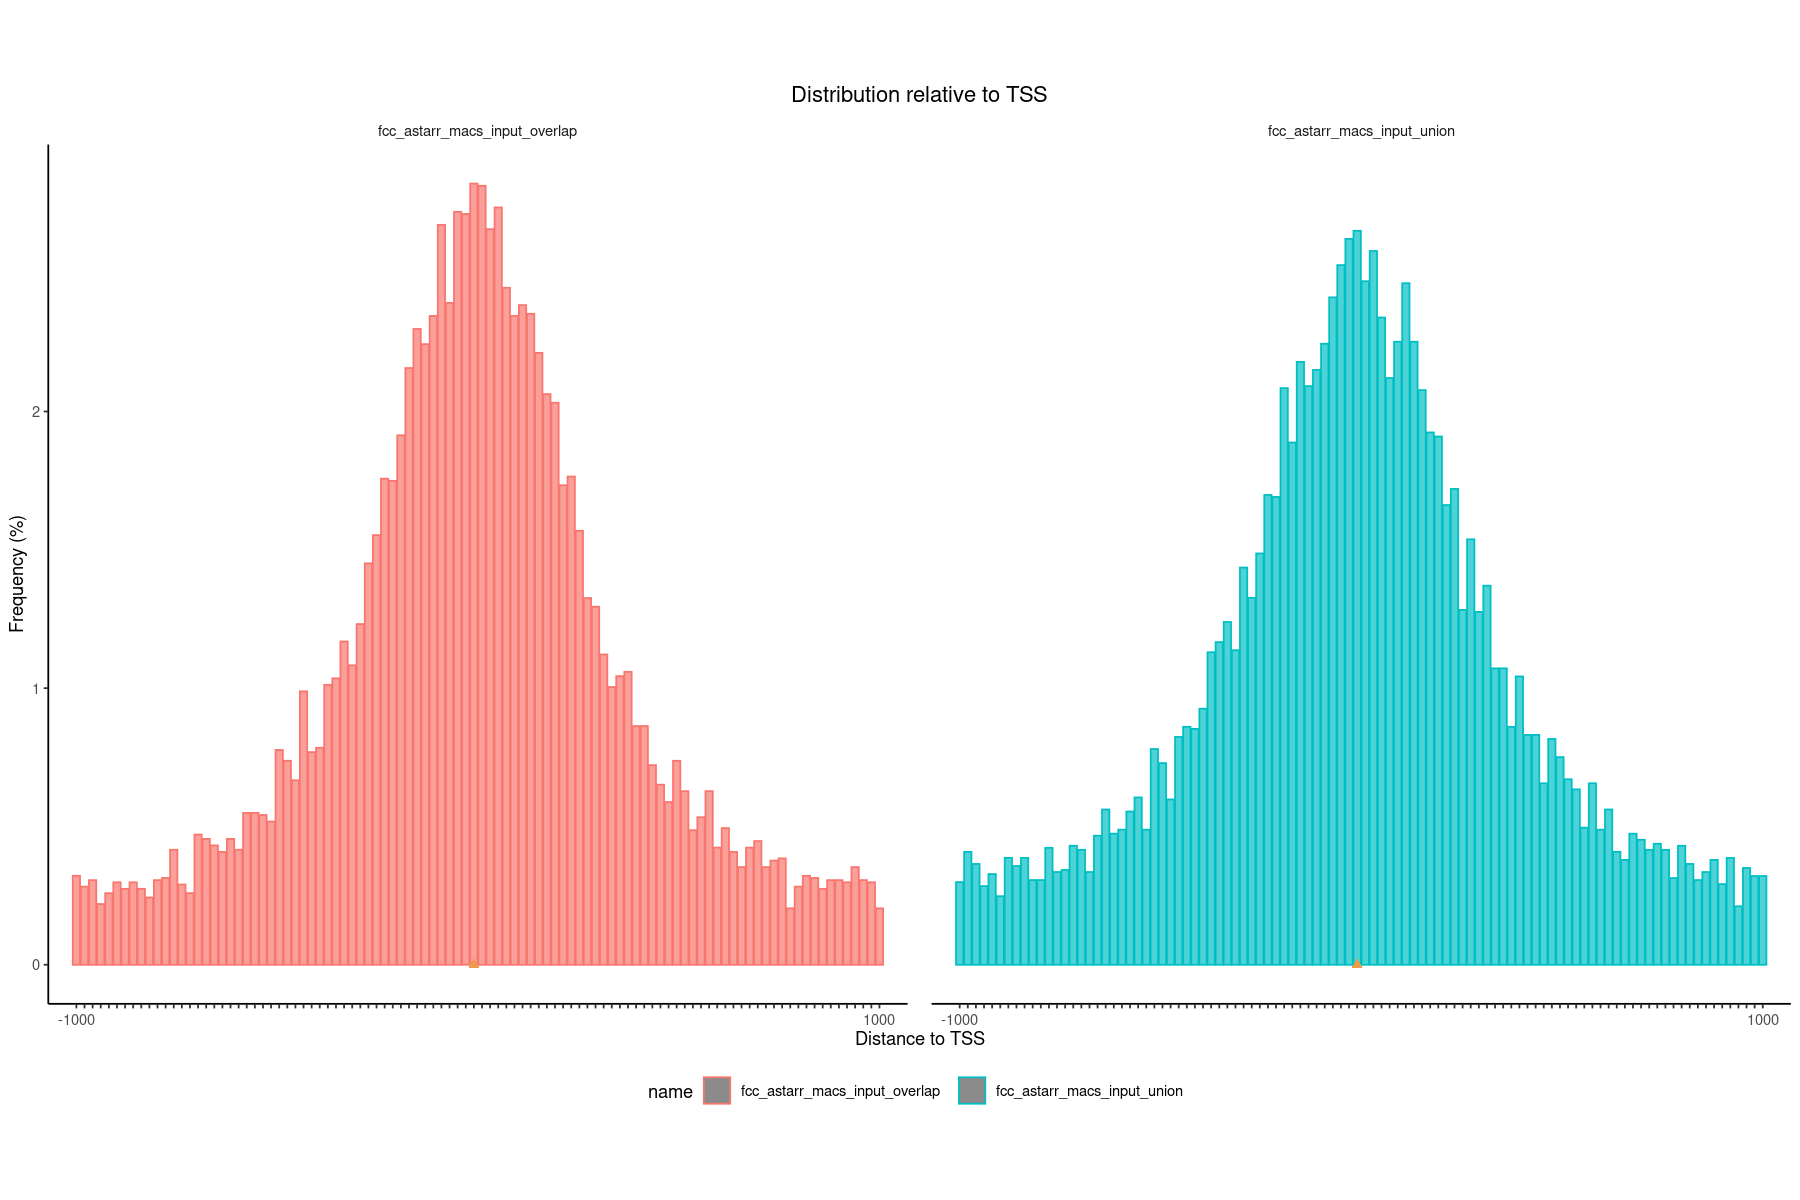

In [21]:
### get data
lst = lst_dat_stats_astarr_input
dat = lst[["fdist_tss_frq"]]

### create and show plot
options(repr.plot.height=10, repr.plot.width=15)
plotFeatureDist(dat, featureName="TSS", size = 1e+03)

**ENCODE Open chromatin regions**

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


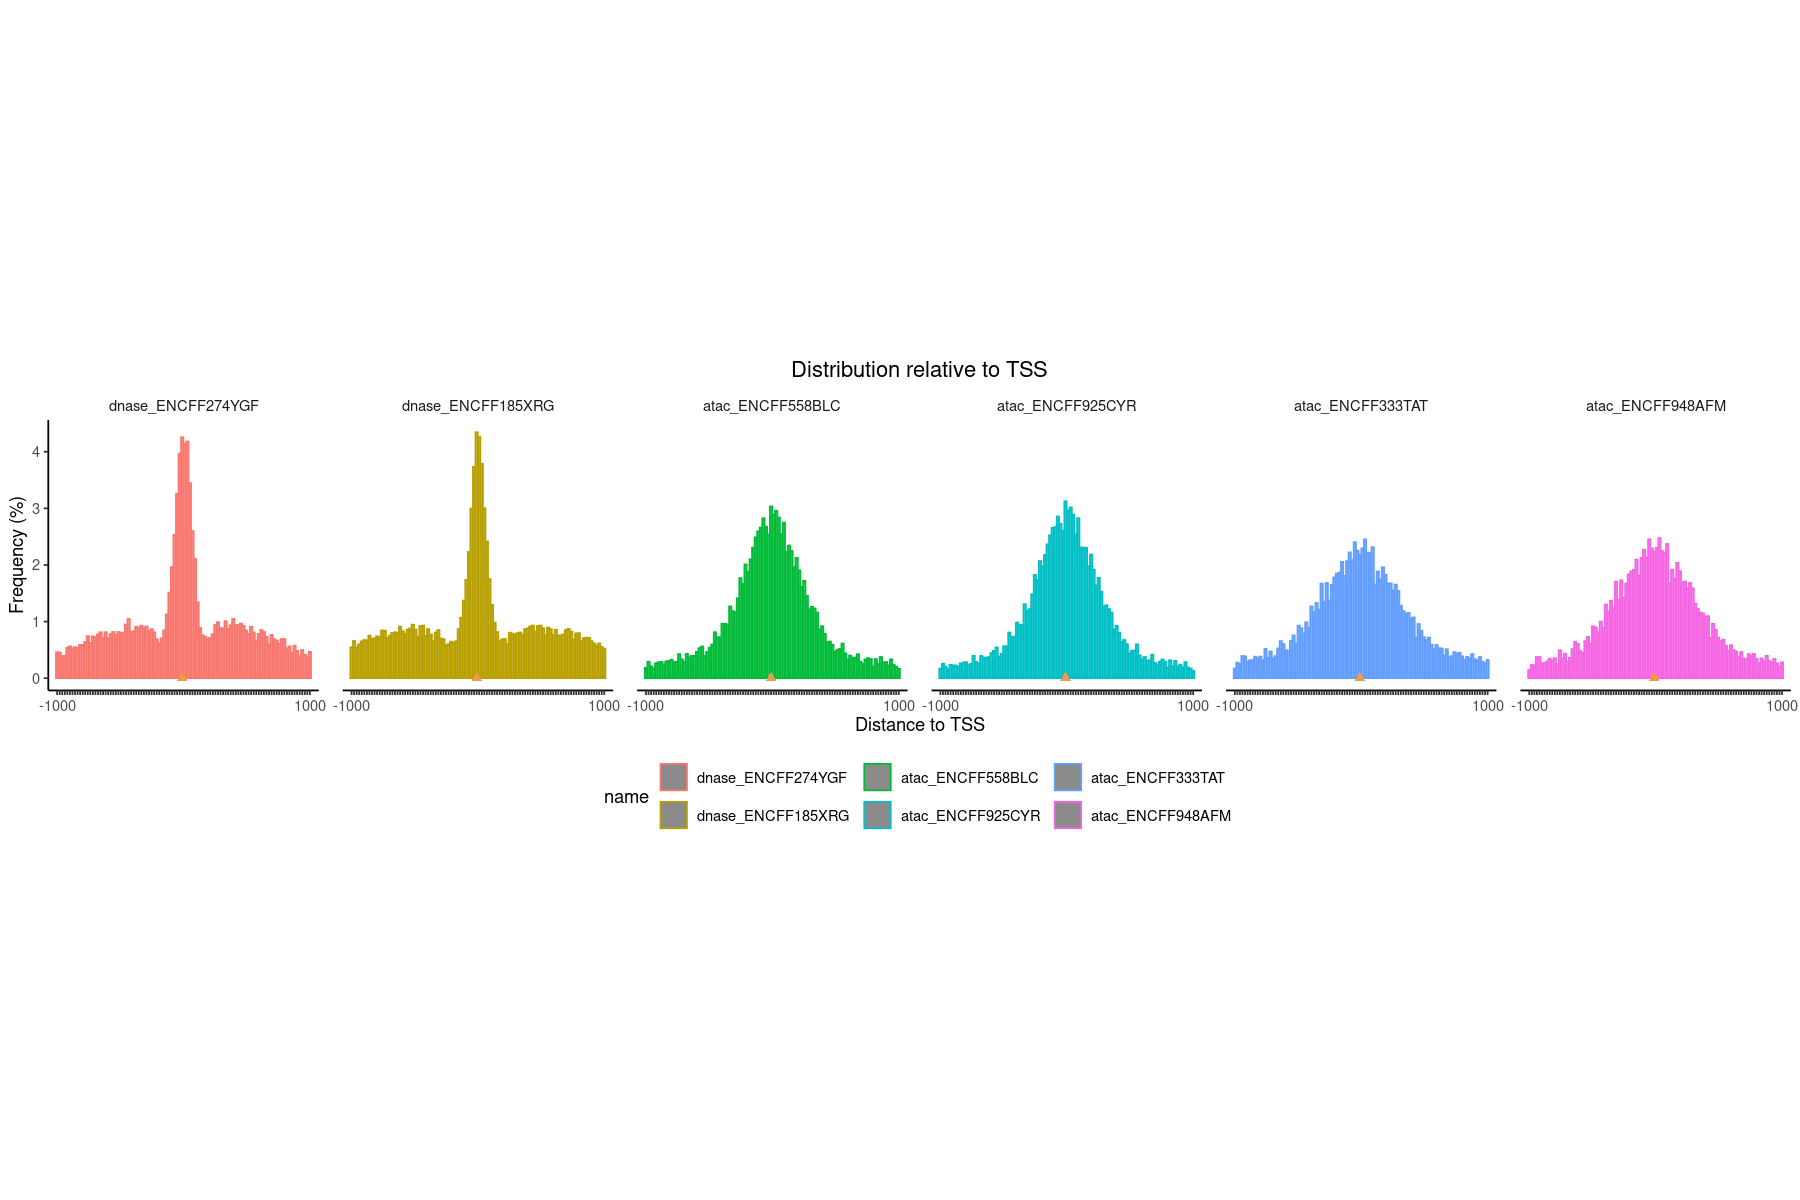

In [22]:
### get data
lst = lst_dat_stats_encode_ocr
dat = lst[["fdist_tss_frq"]]

### create and show plot
options(repr.plot.height=10, repr.plot.width=15)
plotFeatureDist(dat, featureName="TSS", size = 1e+03)